### Preprocess

In [1]:
%%capture
!pip install -r requirements.txt --user

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd
import matplotlib.pyplot as plt

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *
from MyModule.SemanticSimilarityFunctions import *
from MyModule.TopicModelingFunctinos import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

# Summary of each topic

Abstractive summary with T5

In [11]:
t5 = T5Summary()

desafios = df['desafio'].unique()
for des in desafios:
    text = '\n'.join(df[df['desafio']==des]['texto'])
    print(f'Desafio {des}:\n{t5.generate_summary(text, num_beams=10)}\n\n')

ckpt:
josmunpen/mt5-small-spanish-summarization
Desafio 15:
['el estado quiere ayudar a garantizar el derecho a la alimentación y la salud', 'el estado debe ayudar a garantizar el derecho a la alimentación y la salud']


Desafio 13:
['partidos de izquierda "me siento mas identificado con los partidos de izquierda"', 'partidos de izquierda luchan por una distribución de la riqueza más justa']


Desafio 14:
['a ninguna persona, ninguna figura, ninguna figura que me genera esas emociones', 'ella de carloto "no tengo referente de la política argentina"']


Desafio 12:
['la izquierda moderada', 'la izquierda moderada, una persona de izquierda moderada']


Desafio 16:
['los subsidios a las empresas de transportes no son las mismas que cuando fundaron', 'los subsidios a las empresas de transportes no son las mismas que cuando fundaron']


Desafio 17:
['la hora de cursada sea menor', 'la hora de cursada sea menor']


Desafio 18:
['los horarios de cursada', 'los horarios de cursada']




# Select the most representative documents of each desafio's cluster

In [4]:
from MyModule.SummarizationFunctions import MostRepresentativeDocs

pp_object = Preprocess(lemma=False)
mrd = MostRepresentativeDocs()

In [8]:
all_res = {}
for des in df['desafio'].unique():
    data = df[df['desafio']==des]['texto'].values
    result = mrd.get_representatives(data, 3, pp_object)
    all_res[des] = result

## Word count plot

In [5]:
data = df[df['desafio']=='16']['texto'].values

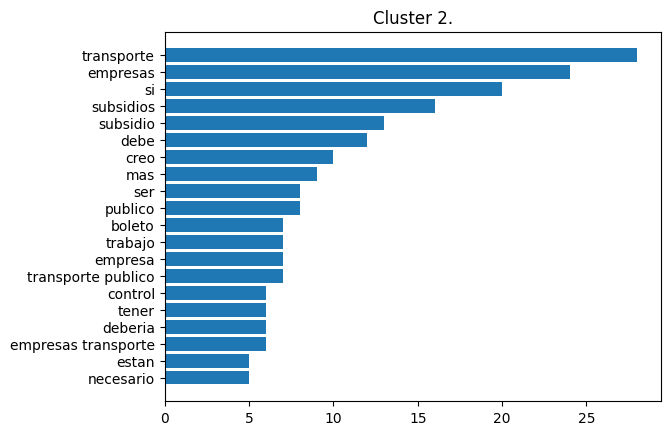

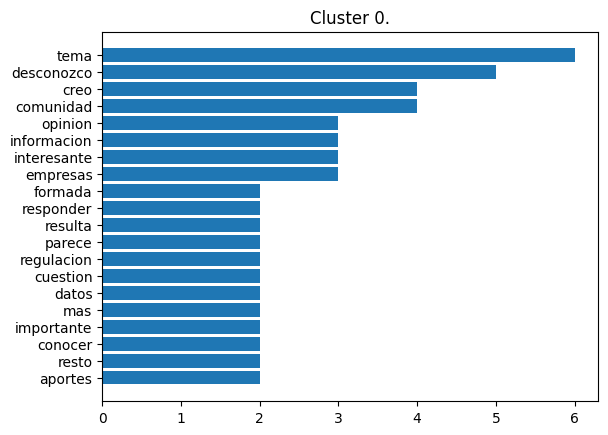

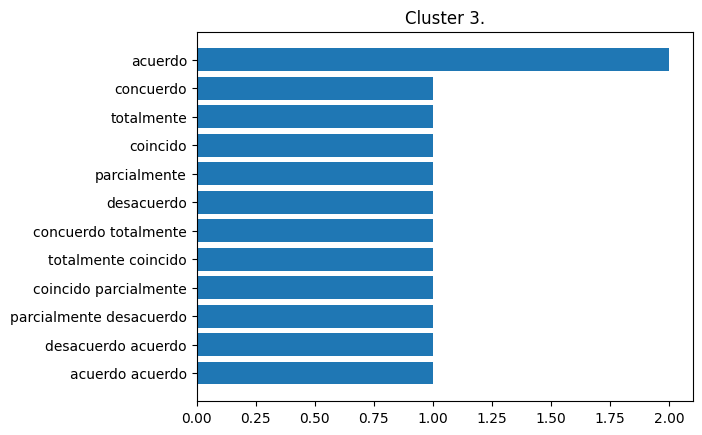

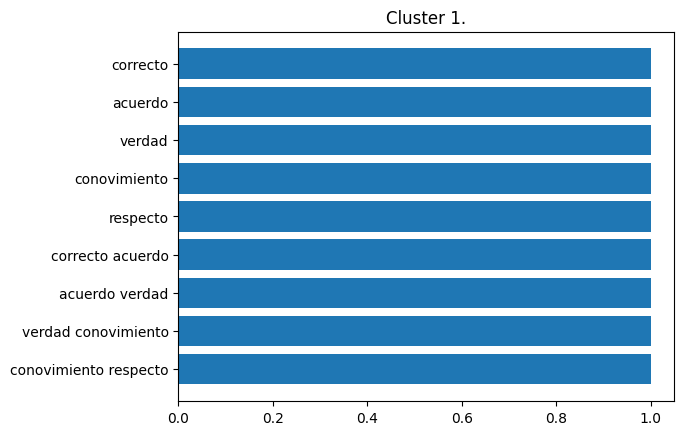

In [6]:
pp_object_transformers = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)
pp_object_word_count = Preprocess(lemma=False)

mrd.plot_word_counts(data, 4, pp_object_transformers=pp_object_transformers, pp_object_word_count=pp_object_word_count)

## Finding optimum K

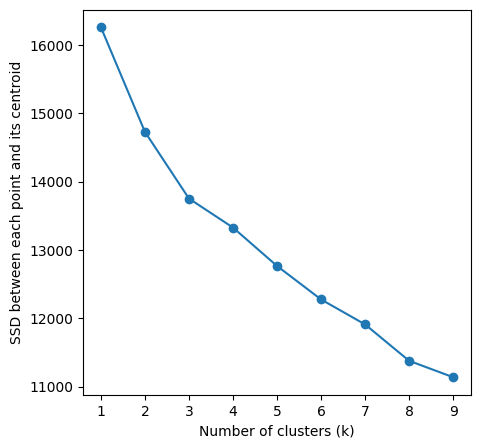

In [7]:
mrd.elbow_method(data, pp_object=pp_object)

## Clusters: Size and Shape

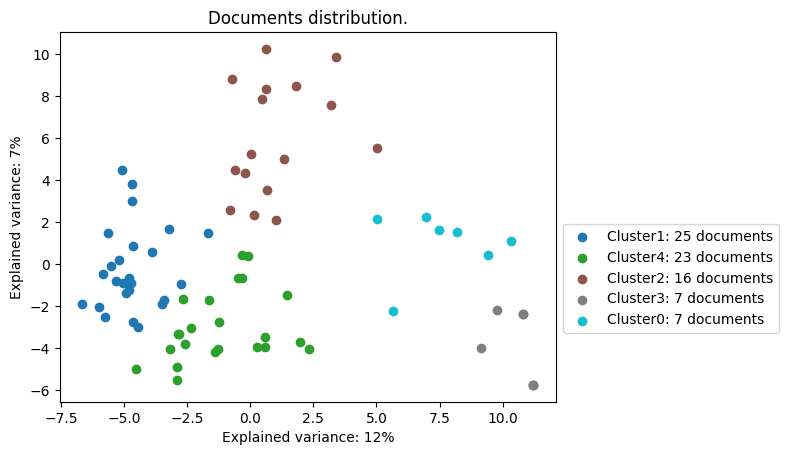

In [6]:
mrd.visualize_documents_kmeans(data, n_clusters=5, pp_object=pp_object)

# Sample representative docs

In [5]:
desafio = '12'

documents = df[df['desafio']==desafio]['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

sr = SampleRepresentatives()
res = sr.get_sample(documents, pp_object=pp_object, n_clusters=5)

In [6]:
print(f'Desafio: {desafio}')
for key, value in res.items():
    print(f'\nCluster: {key}\n')
    for v in value[:3]:
        print(v)

Desafio: 12

Cluster: 2

No tengo una posición muy formada, pero me identifico con el liberalismo. Completamente liberal en lo social, y relativamente en lo económico. 
Creo que las narrativas en términos politicos y económicos actuales no están a la altura del mundo actual. Son ideologías viejas surgidas en contextos totalmente diferentes, no responden a las necesidades del mundo actual, sus problemáticas y sus avances. Estamos viviendo el inicio de la cuarta revolución industrial y tenemos herramientas sociales de la era de los motores a vapor. Pero respondiendo a la consigna; creo que en términos económicos me siento mas identificado con el libre flujo de capitales y con control activo de un BUEN estado. 
Me defino como kirchnerista. Soberania política, independencia económica y justocia social.

Cluster: 0

Nacionalista y popular. Porque considero que la economía se debe manejar en función de los intereses de las mayorías, las clases populares y los intereses nacionales, en defensa

# Combination: summarization for each topic's cluster

In [4]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [39]:
desafio = '12'

original_documents = df.query(f'desafio == "{desafio}"')['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

documents = pp_object.preprocess(original_documents)

emb_docs = model.encode(documents)

In [40]:
n_clusters = 5

kmeans = KMeans(
            init="k-means++",
            n_clusters=n_clusters,
            n_init=10,
            max_iter=300)

In [41]:
kmeans.fit(emb_docs)

KMeans(n_clusters=5, n_init=10)

In [42]:
labeled_docs = {}
for i, orig_doc in enumerate(original_documents):
    current_label = kmeans.labels_[i]
    if current_label in labeled_docs.keys():
        labeled_docs[current_label].append(orig_doc)
    else:
        labeled_docs[current_label] = [orig_doc]

Apply T5 and BETO summarization to each cluster

In [47]:
from time import sleep

beto = BETOSummary()

t5 = T5Summary()

for key, values in labeled_docs.items():
    values = pp_object.preprocess(values)
    text = '.\n'.join(values)
    print(f'BERT, Cluster {key}:\n{beto.generate_summary(text)}\n\n')
    sleep(2)
    print(f'T5, Cluster {key}:\n{t5.generate_summary(text)}\n\n')

ckpt:
mrm8488/bert2bert_shared-spanish-finetuned-summarization


The following encoder weights were not tied to the decoder ['bert/pooler']
The following encoder weights were not tied to the decoder ['bert/pooler']


ckpt:
josmunpen/mt5-small-spanish-summarization
BERT, Cluster 2:
['El estado no tiene por qué intervenir en el mercado, por lo que hemos vivido hasta ahora en este país, queda demostrado', 'El sistema político no tiene por qué intervenir en el mercado, por lo que hemos vivido hasta ahora hasta ahora en este país']


T5, Cluster 2:
['el peronismo, partidos de izquierda "no me siento identificada con el libre flujo de capitales y con control activo de un buen estado"', 'el peronismo, partidos de izquierda y partidos de izquierda']


BERT, Cluster 0:
['El sistema que priorice las libertades individuales tiene mejor funcionamiento que cualquier otro que las cohiba', 'El sistema que priorice las libertades individuales tiene mejor funcionamiento que cualquier otro que las cohiba']


T5, Cluster 0:
['el estado presiona a los derechos humanos y la asistencia a las poblaciones y defender un mercado interno fuerte con buenos salarios', 'el cambio cultural de la cultura argentina']


BERT, Clust

# Word count for each desafio's cluster

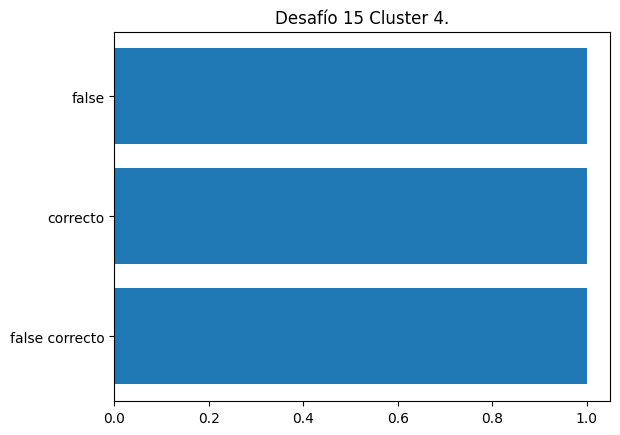

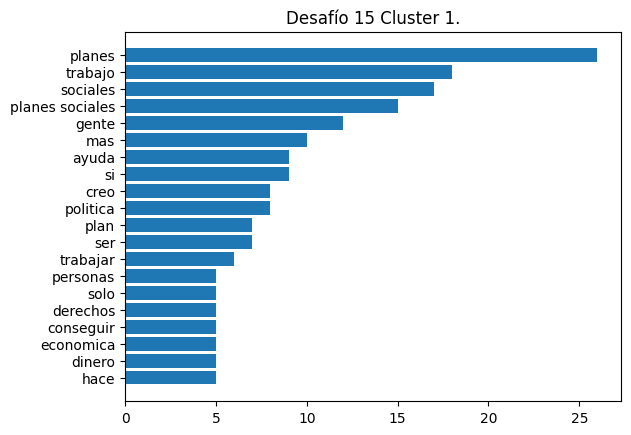

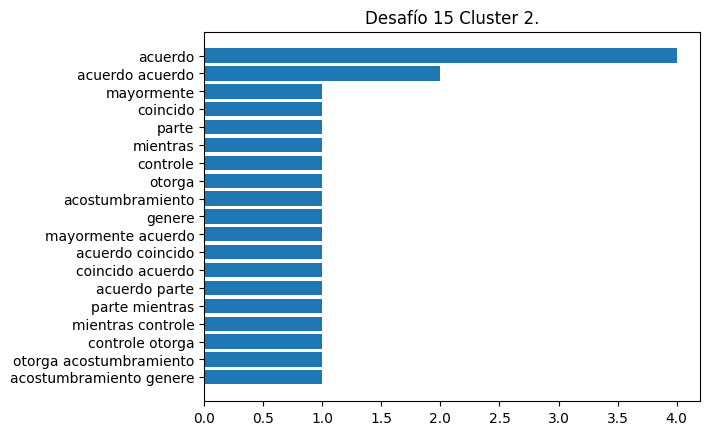

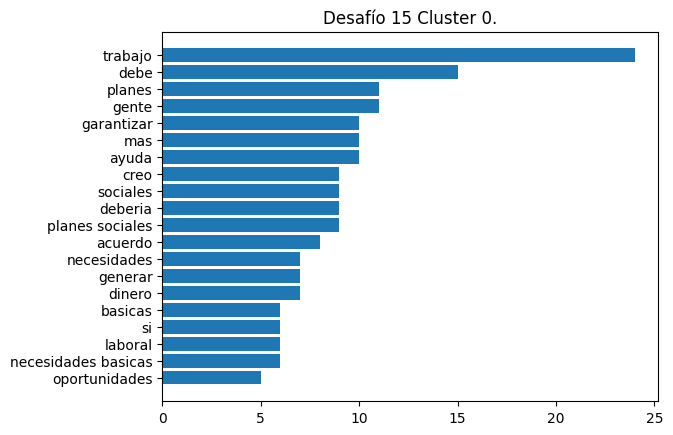

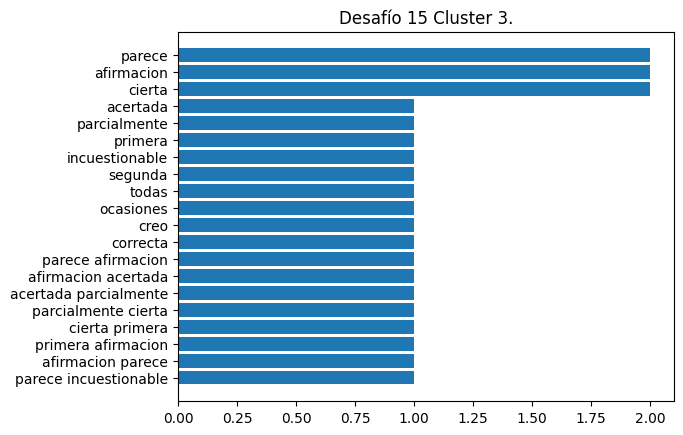

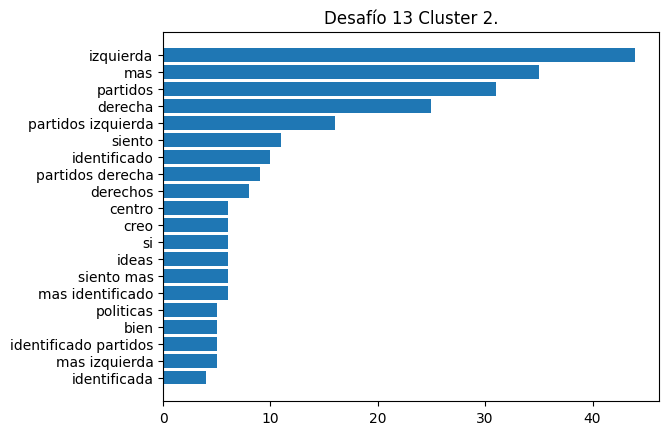

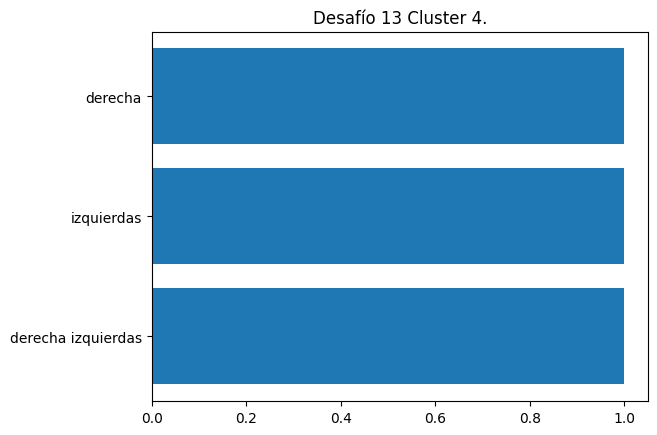

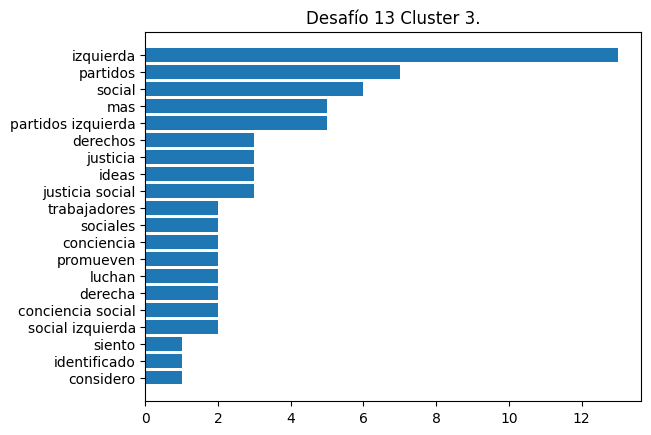

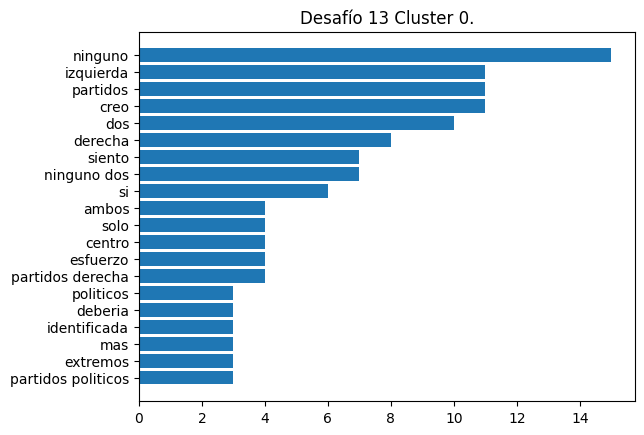

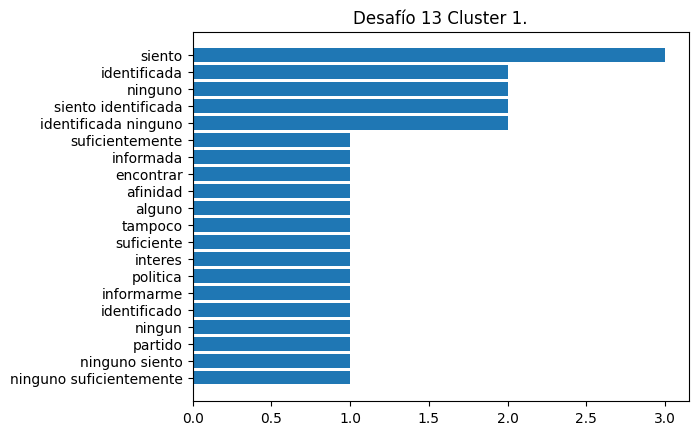

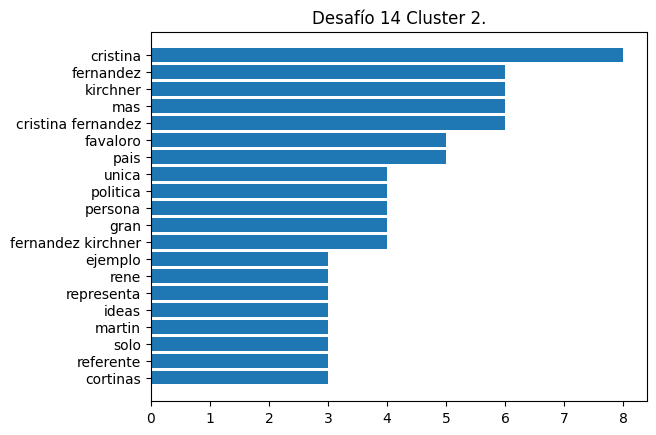

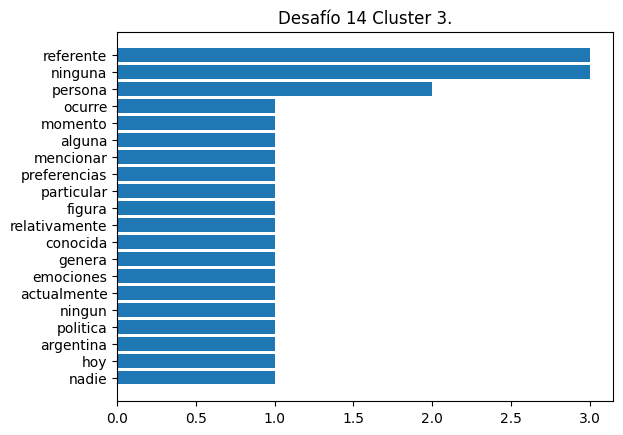

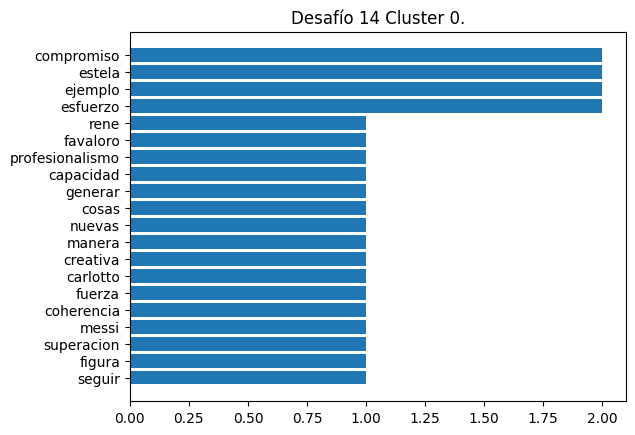

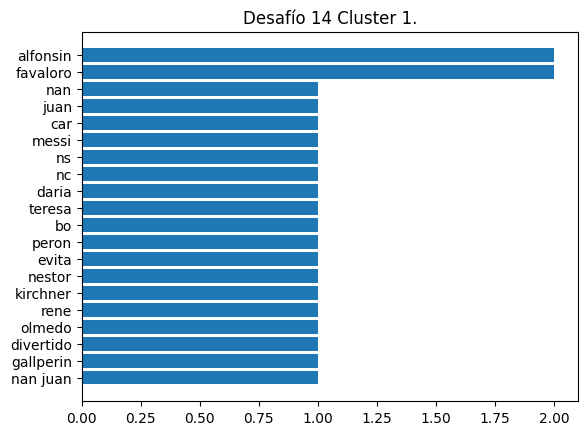

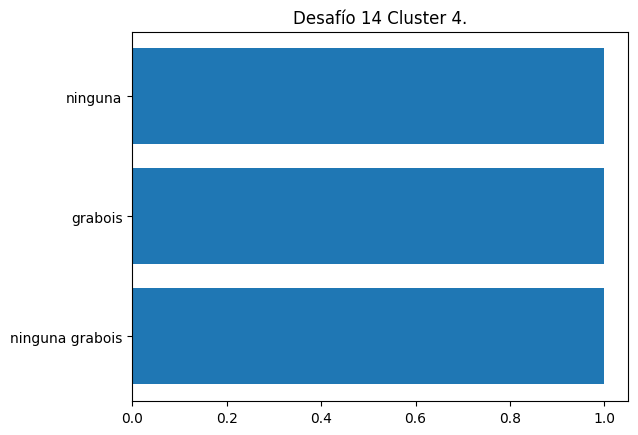

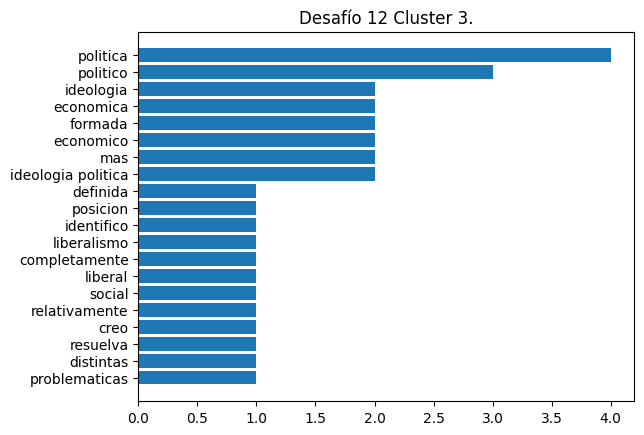

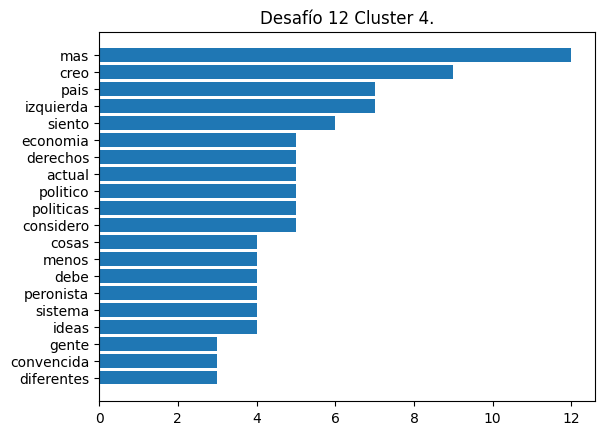

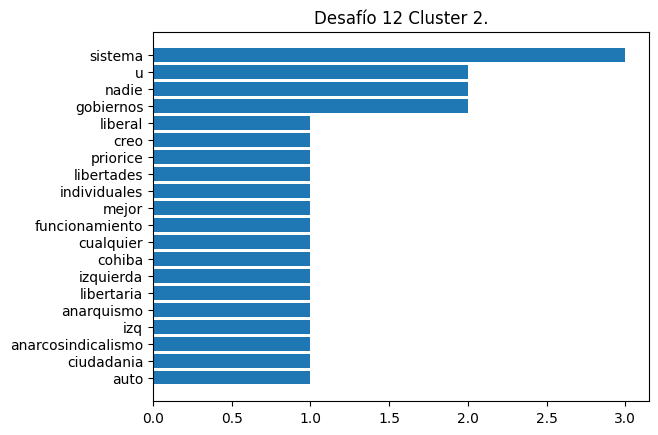

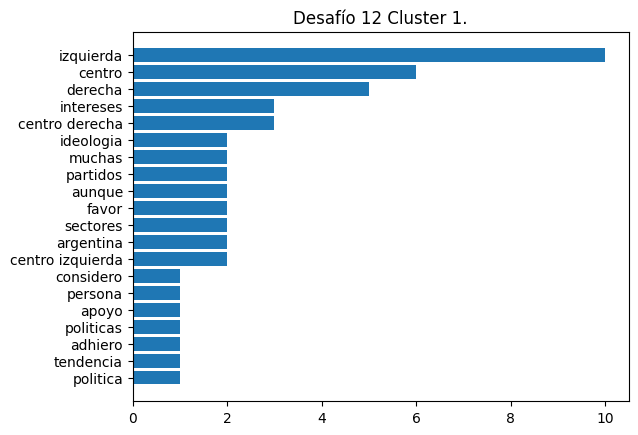

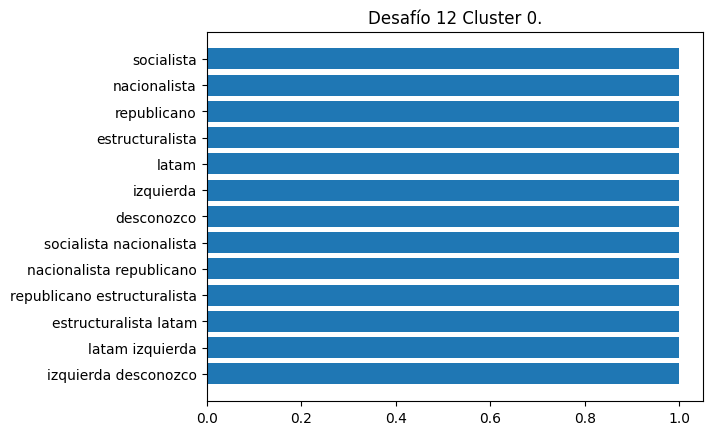

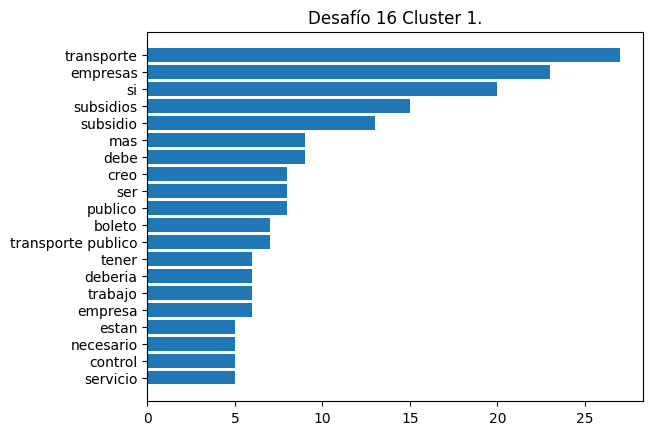

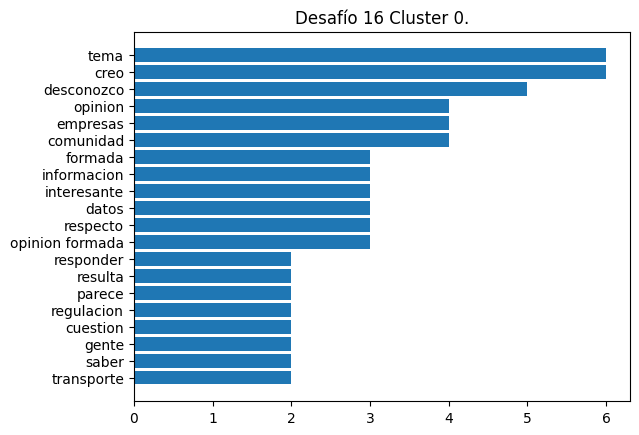

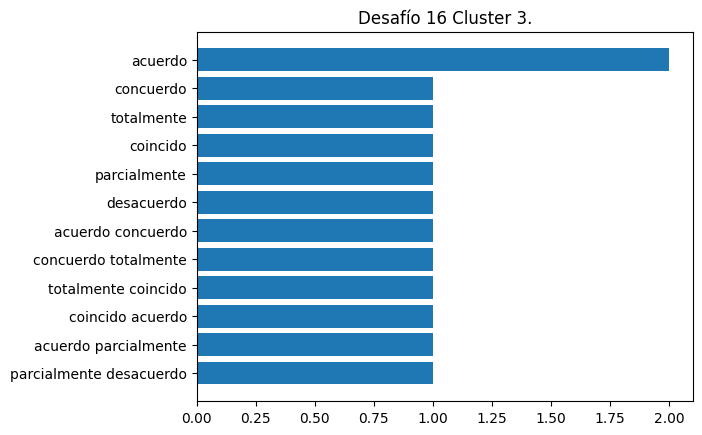

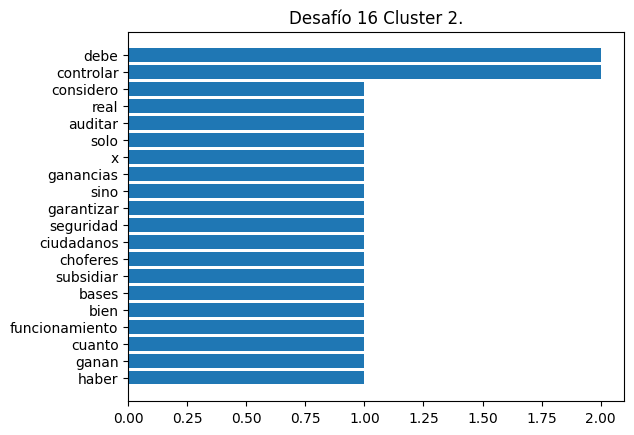

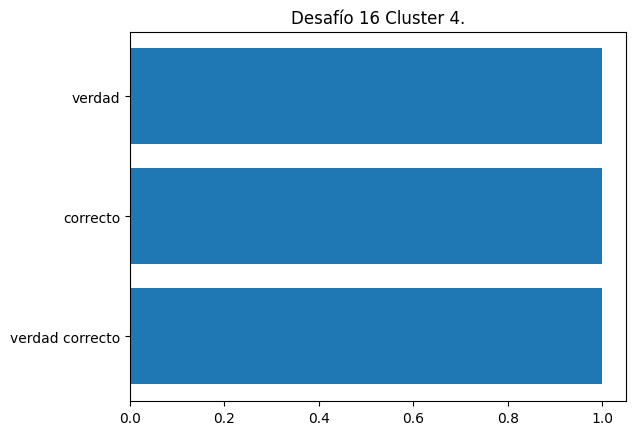

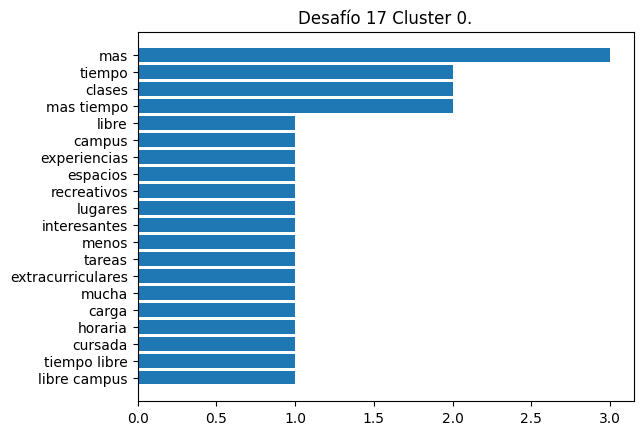

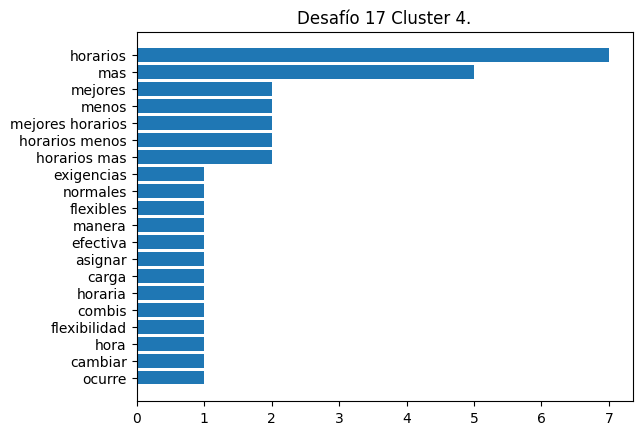

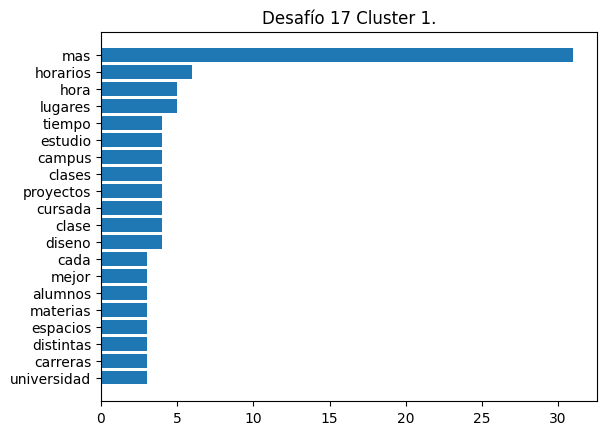

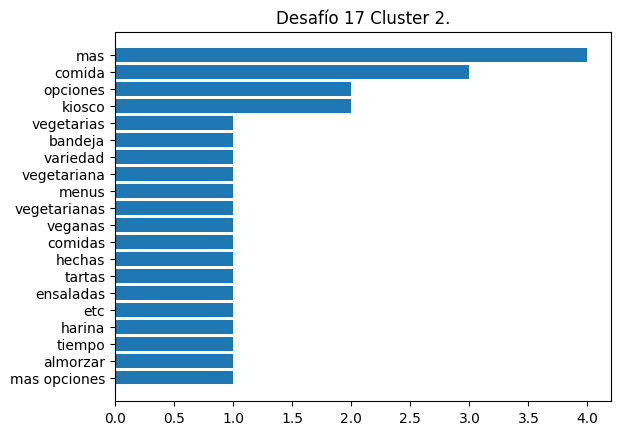

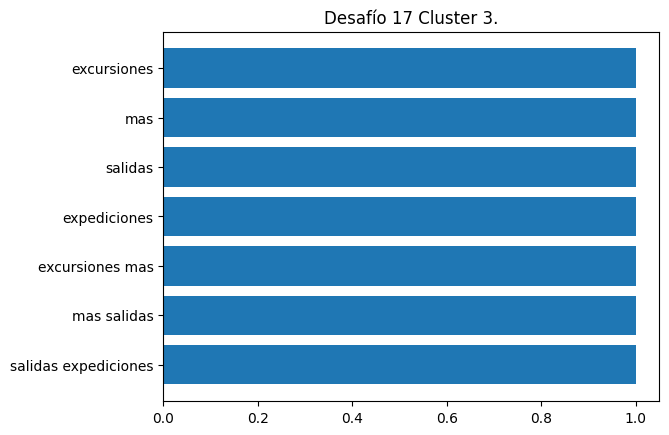

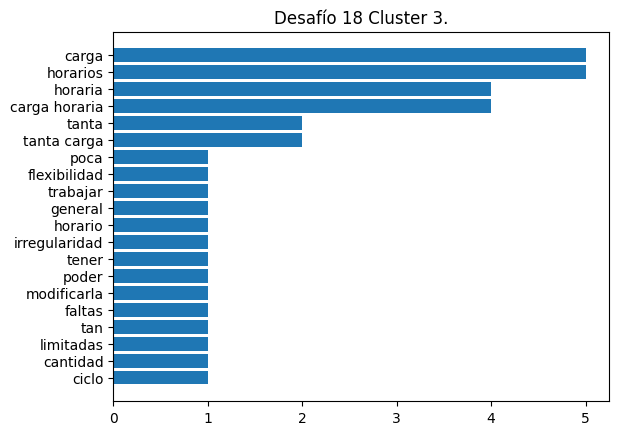

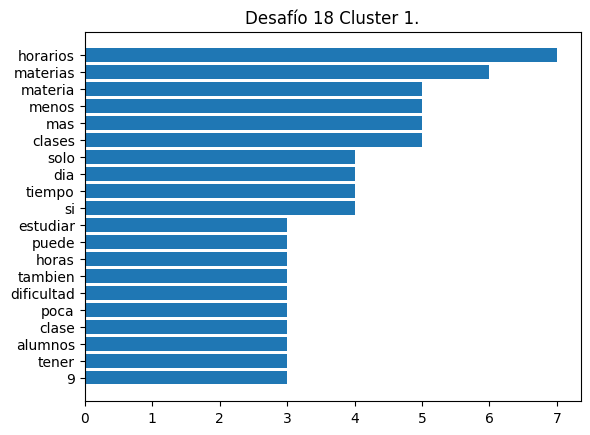

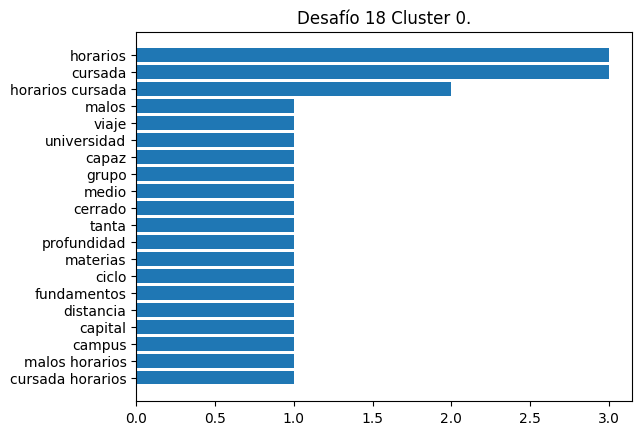

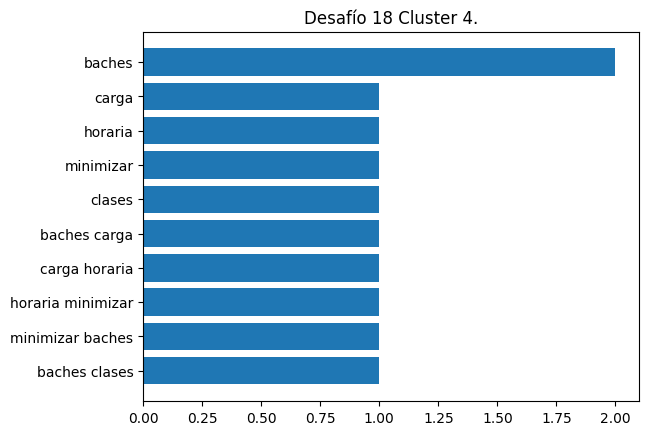

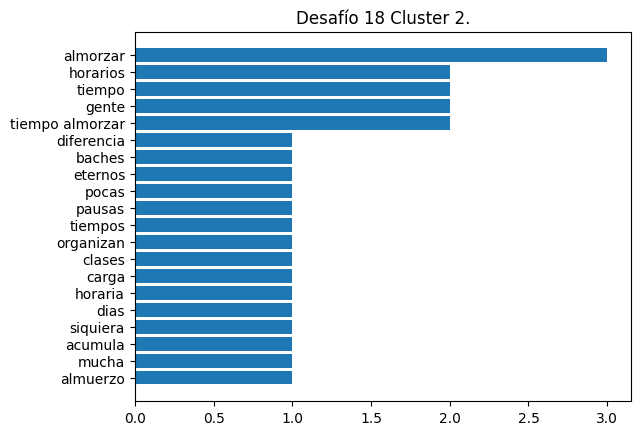

In [117]:
pp_object_word_count = Preprocess(lemma=False)
for key_des, value_des in all_res.items():
    for key_clus, value_clus in value_des.items():
        only_text = [v[0] for v in value_clus]
        pp_only_text = pp_object_word_count.preprocess(' '.join(only_text))[0]
        words_desafio = pp_only_text.split(' ')
        elements, frequencies = count_words(words_desafio)
        plot_word(elements, frequencies, plot_title = f'Desafío {key_des} Cluster {key_clus}.')